Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# Fuel Performance

**Inputs**

- `fuel_dens`: Fuel density ($\frac{kg}{m^3}$)
- `porosity`: Porosity 
- `clad_thick`: Cladding thickness ($m$)
- `pellet_OD`: Pellet outer diameter ($m$)
- `pellet_h`: Pellet height ($m$)
- `gap_thick`: Gap thickness ($m$)
- `inlet_T`: Inlet temperature ($K$)
- `enrich`: U-235 enrichment
- `rough_fuel`: Fuel roughness ($m$)
- `rough_clad`: Clad rouchness ($m$)
- `ax_pow`: Axial power
- `clad_T`: Cladding surface temperature ($K$)
- `pressure`: Pressure ($Pa$)

**Outputs**

- `fis_gas_produced`: Fission gas production ($mol$)
- `max_fuel_centerline_temp`: Max fuel centerline temperature ($K$)
- `max_fuel_surface_temp`: Max fuel surface temperature ($K$)
- `radial_clad_dia`: Radial cladding diameter displacement after irradiation ($m$)

This data set consists of 13 inputs and 4 outputs with 400 data points. This data originates from [[RK20]](https://pymaise.readthedocs.io/en/stable/index.html#id3), and a graphical representation is provided in the figure below. Case 1 from the pellet-cladding mechanical interaction (PCMI) benchmark was selected for the data set. This benchmark simulates a beginning of life (BOL) ramp of a 10-pellet pressurized water reactor (PWR) fuel rod to an average linear heat rate of $40~kW/m$. The inner and outer cladding diameters are reduced, so the fuel-clad interaction occurs during the ramp time. Axial power and rod surface temperature profiles were assumed to be uniform at $330^\circ C$. The 13 input parameters were uniformly randomly sampled independently within their uncertainty bounds and simulated in BISON. The rod response was recorded in 4 outputs.

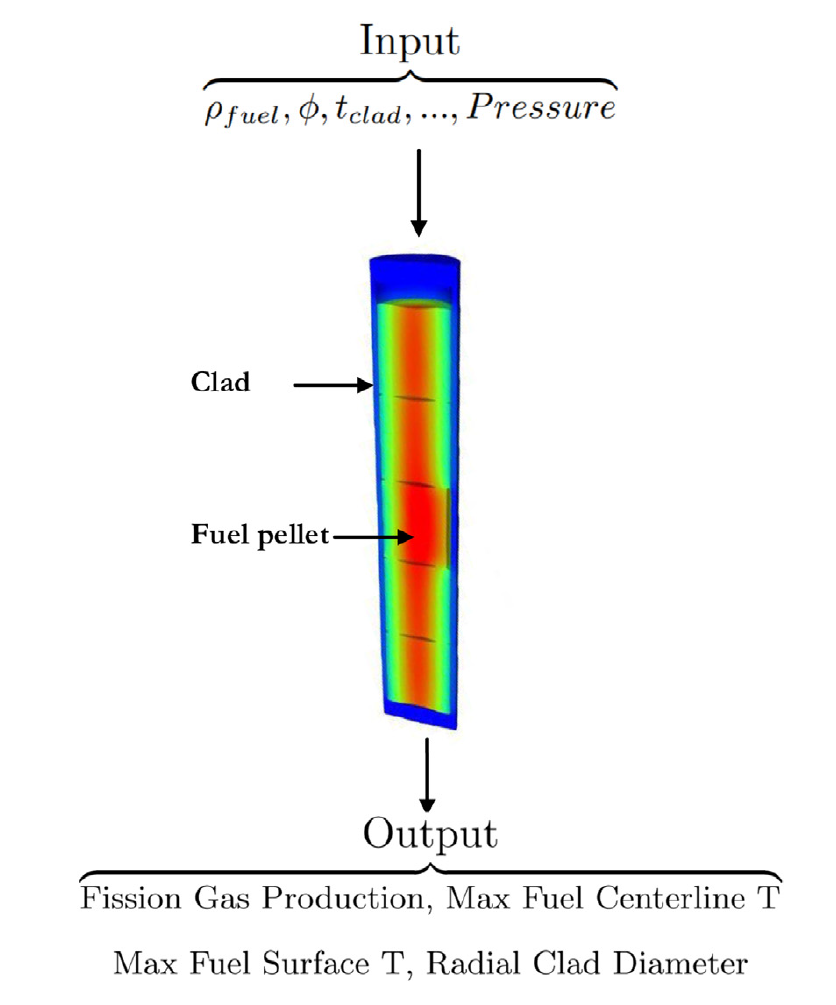


The following are a few common packages and functions that will prove useful while using pyMAISE along with pyMAISE specific functionality. 

In [2]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_fp
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We first start by initializing pyMAISE settings and then import the data set using `pyMAISE.datasets.load_fp()` from the pyMAISE dataset library.

In [8]:
# Constructing pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data
data, inputs, outputs = load_fp()

As stated the data set consists of 13 inputs:

In [9]:
inputs

<xarray.DataArray (index: 400, variable: 13)>
array([[1.0466e+04, 4.0527e-02, 5.7110e-04, ..., 9.9967e-01, 6.0272e+02,
        1.5504e+07],
       [1.0488e+04, 4.1780e-02, 5.6984e-04, ..., 9.8741e-01, 6.0281e+02,
        1.5591e+07],
       [1.0434e+04, 5.8323e-02, 5.6760e-04, ..., 9.9225e-01, 6.2033e+02,
        1.5510e+07],
       ...,
       [1.0474e+04, 4.9933e-02, 5.6787e-04, ..., 9.7834e-01, 5.9643e+02,
        1.5645e+07],
       [1.0456e+04, 4.4766e-02, 5.7574e-04, ..., 9.5912e-01, 5.9159e+02,
        1.5441e+07],
       [1.0438e+04, 5.5806e-02, 5.7198e-04, ..., 9.9917e-01, 6.0763e+02,
        1.5379e+07]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fuel_dens' 'porosity' ... 'clad_T' 'pressure'

and 4 outputs with 400 total data points:

In [10]:
outputs

<xarray.DataArray (index: 400, variable: 4)>
array([[2.95000000e-05, 1.56969931e+03, 6.99613033e+02, 1.88000000e-05],
       [3.17000000e-05, 1.55946516e+03, 6.99976191e+02, 1.87000000e-05],
       [3.11000000e-05, 1.63239410e+03, 7.12771506e+02, 2.02000000e-05],
       ...,
       [3.04000000e-05, 1.55122859e+03, 6.92270857e+02, 1.81000000e-05],
       [3.09000000e-05, 1.50301759e+03, 6.83481715e+02, 1.72000000e-05],
       [3.17000000e-05, 1.62006353e+03, 7.04130846e+02, 1.98000000e-05]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fis_gas_produced' ... 'radial_clad_dia'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

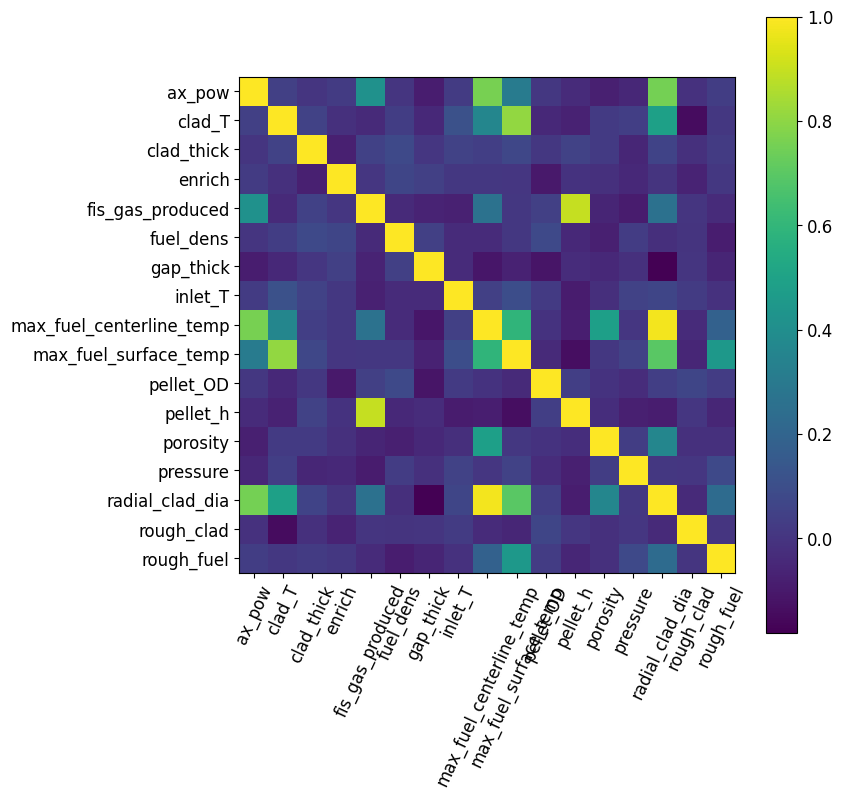

In [11]:
correlation_matrix(data)

There is a positive correlation between axial power and cladding temperature with max fuel centerline temperature, max fuel surface temperature, and radial cladding diameter. Additionally, the fission gas production correlates with pellet height.

The final step of the pyMAISE processing is splitting and data scaling. For this data set we will use min-max scaling.

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 6 models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyper-parameter tuning each model we must be initialized the archetecture and optimization search spaces.

In [13]:
# Initializing all the models wanted along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

We will use random search for the hyperparameter tuning of the classical models (`Lasso`, `DT`, `RF`, and `KN`) through the `pyMAISE.Tuner.random_search` function. `Linear` will be manually fit with the Scikit-learn defaults. For each classical model 300 models will be produced with randomly sampled parameter configurations. For `FNN`, Bayesian search is used to optimize the hyper-parameters in 50 iterations through the `pyMAISE.Tuner.nn_bayesian_search` function. Bayesian search is appealing for `FNN` as their training can be computationally expensive. To further reduce the computational cost of `FNN` we specify only 10 epochs which will produce less than performant models but show the optimal parameters. For both search methods we use cross-validation to reduce bias in the models from the data set. The hyperparameter search spaces are defined in the `random_search_spaces` and `bayesian_search_spaces` dictionaries.

In [14]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 10s]
r2_score: 0.939068635478604

Best r2_score So Far: 0.9698019805436695
Total elapsed time: 00h 07m 12s
Hyperparameter tuning took 11.577727540334065 minutes to process.


We can understand the hyperparameter tuning of Bayesian search from the convergence plot.

(0.0, 1.0)

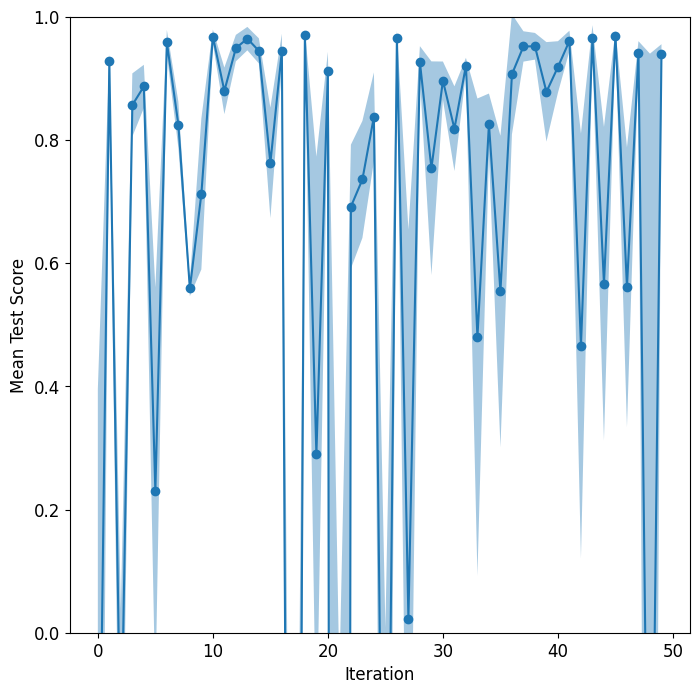

In [29]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

## Model Postprocessing

Now that the top `pyMAISE.Settings.num_configs_saved` saved, we can pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. To improve the `FNN` performance we can pass an updated epochs parameter. Using 200 epochs should improve fitting at higher computational cost.

In [16]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"epochs": 200},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we compute 4 regression metrics for both the training and testing data starting with `fis_gas_produced`.

In [17]:
postprocessor.metrics(y="fis_gas_produced")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999263,3.294860e-08,1.654134e-15,4.067104e-08,0.999236,3.247840e-08,1.653535e-15,4.066368e-08
2,Lasso,{'alpha': 0.00013746294320359566},0.999191,3.433711e-08,1.817270e-15,4.262945e-08,0.999172,3.308970e-08,1.790525e-15,4.231460e-08
1,Lasso,{'alpha': 0.00015340074671565132},0.999180,3.447334e-08,1.841575e-15,4.291358e-08,0.999157,3.324381e-08,1.823090e-15,4.269766e-08
3,Lasso,{'alpha': 0.00023069684818728025},0.999111,3.545484e-08,1.997236e-15,4.469045e-08,0.999068,3.443538e-08,2.016568e-15,4.490621e-08
4,Lasso,{'alpha': 0.00043186681732516083},0.998799,3.948322e-08,2.696067e-15,5.192366e-08,0.998707,4.001809e-08,2.796383e-15,5.288084e-08
5,Lasso,{'alpha': 0.00045998529560637704},0.998741,4.029105e-08,2.827549e-15,5.317470e-08,0.998642,4.098162e-08,2.937178e-15,5.419574e-08
23,FNN,"{'Dense_input_0_units': 216, 'Dense_input_0_su...",0.998777,3.978977e-08,2.746662e-15,5.240861e-08,0.997793,4.895183e-08,4.774287e-15,6.909621e-08
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.998458,4.790501e-08,3.462324e-15,5.884151e-08,0.997645,5.518216e-08,5.093612e-15,7.136955e-08
24,FNN,"{'Dense_input_0_units': 237, 'Dense_input_0_su...",0.998305,4.972976e-08,3.805750e-15,6.169076e-08,0.997432,5.782065e-08,5.554219e-15,7.452663e-08
25,FNN,"{'Dense_input_0_units': 197, 'Dense_input_0_su...",0.996805,7.537548e-08,7.176102e-15,8.471187e-08,0.995860,8.470730e-08,8.955121e-15,9.463150e-08


Fission gas production is well modeled by linear regression, lasso regression, and the FNNs. Random forest, decision tree, and k-nearest neighbors overfit.

In [18]:
postprocessor.metrics(y="max_fuel_centerline_temp")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.998121,1.218360,2.655492,1.629568,0.996734,1.658546,4.603700,2.145623
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.997010,1.688480,4.225590,2.055624,0.996576,1.796863,4.825650,2.196736
2,Lasso,{'alpha': 0.00013746294320359566},0.996800,1.710576,4.521984,2.126496,0.996486,1.801077,4.952641,2.225453
1,Lasso,{'alpha': 0.00015340074671565132},0.996757,1.718759,4.583056,2.140807,0.996456,1.812164,4.995440,2.235048
3,Lasso,{'alpha': 0.00023069684818728025},0.996504,1.764070,4.941265,2.222896,0.996238,1.883536,5.302521,2.302720
24,FNN,"{'Dense_input_0_units': 237, 'Dense_input_0_su...",0.997136,1.508092,4.047548,2.011852,0.995731,1.906685,6.016868,2.452930
4,Lasso,{'alpha': 0.00043186681732516083},0.995526,1.935290,6.323640,2.514685,0.995252,2.090386,6.691825,2.586856
5,Lasso,{'alpha': 0.00045998529560637704},0.995368,1.965203,6.546899,2.558691,0.995077,2.122555,6.938834,2.634167
23,FNN,"{'Dense_input_0_units': 216, 'Dense_input_0_su...",0.995965,1.931031,5.702131,2.387914,0.994184,2.273205,8.197726,2.863167
25,FNN,"{'Dense_input_0_units': 197, 'Dense_input_0_su...",0.990807,3.178275,12.992556,3.604519,0.990694,3.113245,13.117380,3.621792


The max fuel centerline temperature follows the results for fission gas production.

In [19]:
postprocessor.metrics(y="max_fuel_surface_temp")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 343, 'Dense_input_0_su...",0.970003,1.044025,1.748201,1.322196,0.954981,1.343805,2.927129,1.710886
24,FNN,"{'Dense_input_0_units': 237, 'Dense_input_0_su...",0.960882,1.253540,2.279765,1.509889,0.945669,1.542376,3.532618,1.879526
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.948462,1.346747,3.003587,1.733086,0.937927,1.642241,4.036010,2.008982
23,FNN,"{'Dense_input_0_units': 216, 'Dense_input_0_su...",0.932046,1.741735,3.960308,1.990052,0.929612,1.891432,4.576700,2.139322
25,FNN,"{'Dense_input_0_units': 197, 'Dense_input_0_su...",0.930374,1.735841,4.057729,2.014381,0.929048,1.908847,4.613320,2.147864
1,Lasso,{'alpha': 0.00015340074671565132},0.919477,1.878202,4.692805,2.166288,0.929009,1.903085,4.615883,2.148461
2,Lasso,{'alpha': 0.00013746294320359566},0.919549,1.877070,4.688601,2.165318,0.929008,1.902257,4.615943,2.148475
3,Lasso,{'alpha': 0.00023069684818728025},0.919070,1.883992,4.716515,2.171754,0.928744,1.908712,4.633138,2.152473
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.919848,1.868683,4.671205,2.161297,0.928521,1.899599,4.647619,2.155834
4,Lasso,{'alpha': 0.00043186681732516083},0.917651,1.898505,4.799246,2.190718,0.927638,1.924082,4.705016,2.169105


The max fuel surface temperature is the output with the worst results for all models. The FNNs did the best with one configuration having a test $R^2$ greater than 0.95.

In [20]:
postprocessor.metrics(y="radial_clad_dia")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
25,FNN,"{'Dense_input_0_units': 197, 'Dense_input_0_su...",0.997610,3.104900e-08,1.585953e-15,3.982403e-08,0.996584,3.539181e-08,2.109531e-15,4.592963e-08
23,FNN,"{'Dense_input_0_units': 216, 'Dense_input_0_su...",0.997814,3.040732e-08,1.450780e-15,3.808911e-08,0.996241,3.640978e-08,2.321330e-15,4.818019e-08
2,Lasso,{'alpha': 0.00013746294320359566},0.996917,3.512767e-08,2.045854e-15,4.523112e-08,0.996016,3.810351e-08,2.460460e-15,4.960302e-08
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.997142,3.421915e-08,1.896928e-15,4.355374e-08,0.995995,3.854094e-08,2.473536e-15,4.973465e-08
1,Lasso,{'alpha': 0.00015340074671565132},0.996867,3.535437e-08,2.079489e-15,4.560141e-08,0.995978,3.827900e-08,2.483744e-15,4.983718e-08
3,Lasso,{'alpha': 0.00023069684818728025},0.996542,3.725998e-08,2.294883e-15,4.790493e-08,0.995699,3.935765e-08,2.656317e-15,5.153947e-08
4,Lasso,{'alpha': 0.00043186681732516083},0.995269,4.389152e-08,3.139720e-15,5.603321e-08,0.994467,4.514944e-08,3.417289e-15,5.845759e-08
24,FNN,"{'Dense_input_0_units': 237, 'Dense_input_0_su...",0.995746,4.191213e-08,2.822905e-15,5.313102e-08,0.994292,4.654180e-08,3.524915e-15,5.937099e-08
5,Lasso,{'alpha': 0.00045998529560637704},0.995053,4.488801e-08,3.282890e-15,5.729651e-08,0.994234,4.630588e-08,3.560787e-15,5.967233e-08
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.984439,9.472829e-08,1.032709e-14,1.016223e-07,0.982564,9.322207e-08,1.076807e-14,1.037693e-07


Performance for radial cladding diameter follows the results of fission gas production and max fuel centerline temperature.

In [21]:
postprocessor.metrics()[["Model Types", "Train R2", "Test R2"]]

,Model Types,Train R2,Test R2
24,FNN,0.988017,0.983281
2,Lasso,0.978114,0.980171
1,Lasso,0.978070,0.980150
0,Linear,0.978316,0.980082
3,Lasso,0.977807,0.979937
23,FNN,0.981151,0.979457
4,Lasso,0.976811,0.979016
5,Lasso,0.976641,0.978856
22,FNN,0.982370,0.978717
25,FNN,0.978899,0.978046


Overall the FNN performed the best given its performance on max fuel surface temperature. This was followed by linear and lasso regression. Random forest, decision tree, and k-nearest neighbors overfit.

We can see the parameters of each model with the best test $R^2$ with `pyMAISE.PostProcessor.get_params`.

In [22]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00013746294320359566

Model Types: DT
max_depth: 12
max_features: None
min_samples_leaf: 5
min_samples_split: 4

Model Types: RF
criterion: poisson
max_features: None
min_samples_leaf: 2
min_samples_split: 4
n_estimators: 166

Model Types: KN
leaf_size: 1
n_neighbors: 8
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 237
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.4
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.001
batch_size: 8
Dense_hidden_0_units: 250
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.37921032406412414
Dense_hidden_1_units: 40
Dense_hidden_1_sublayer: Dropout_hidden
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.449838851029177



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output.

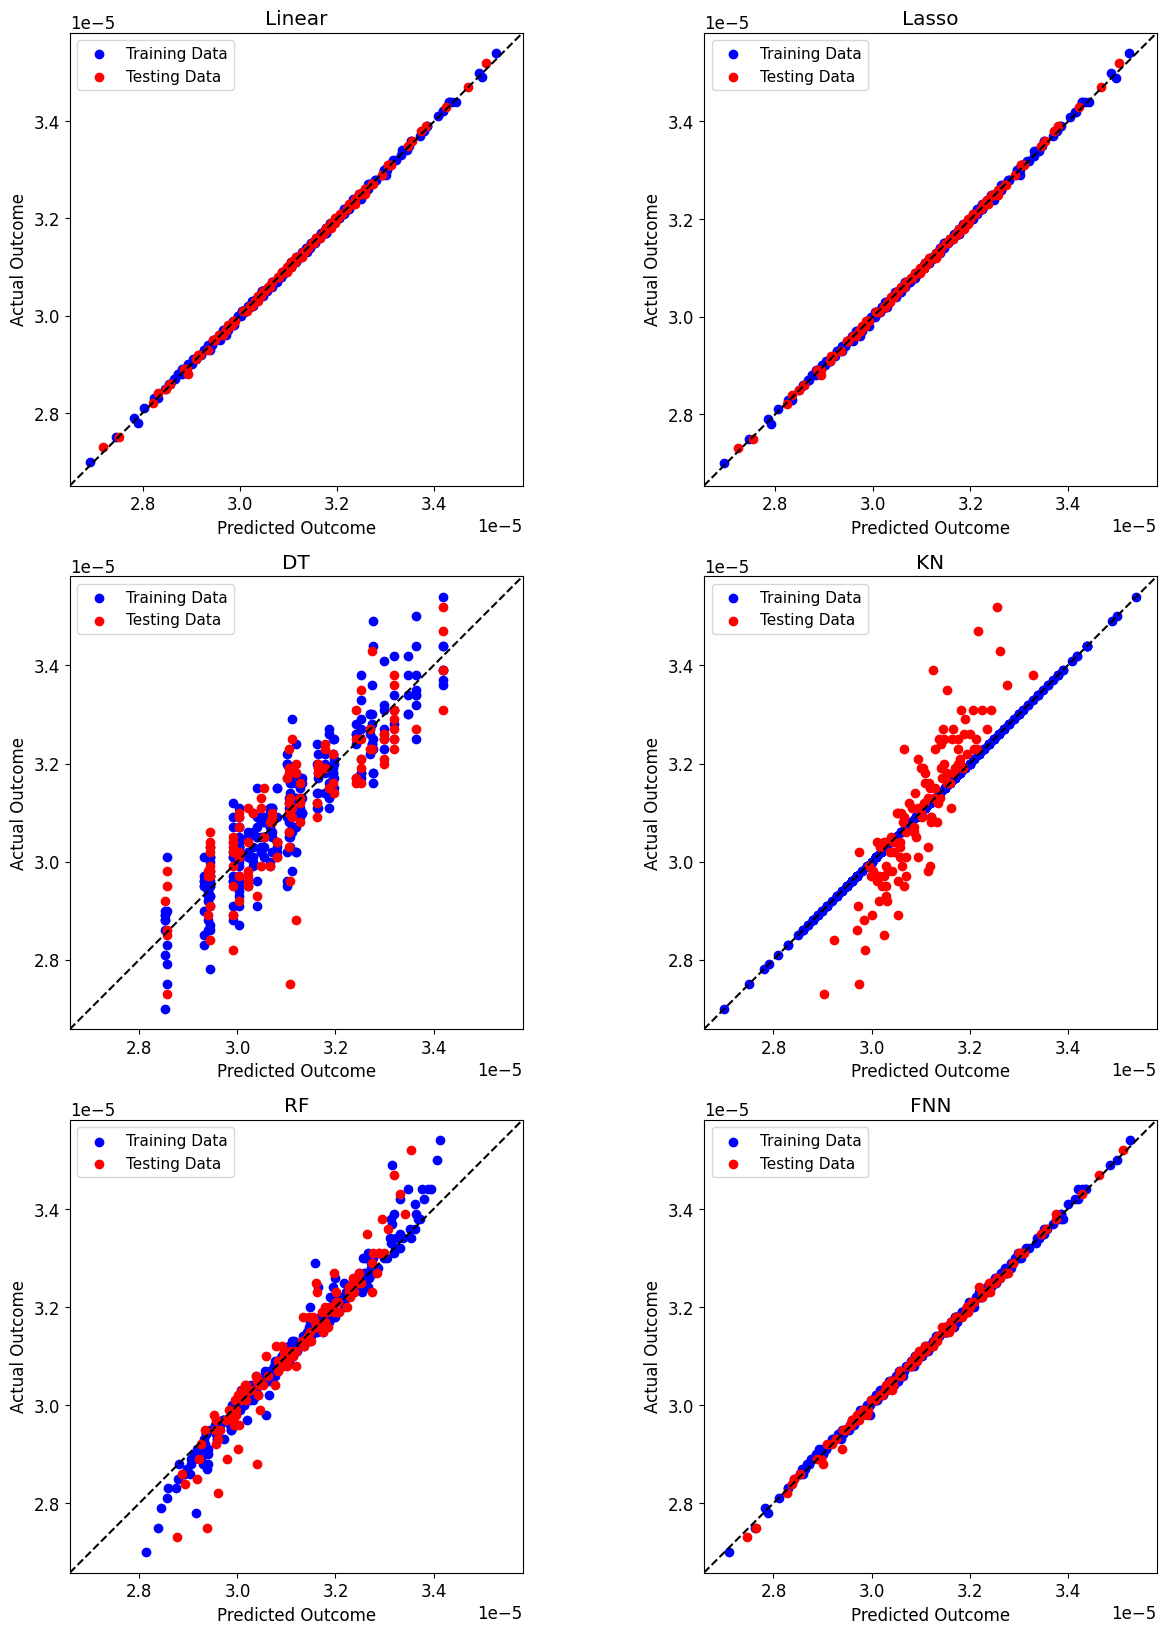

In [23]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "fis_gas_produced")

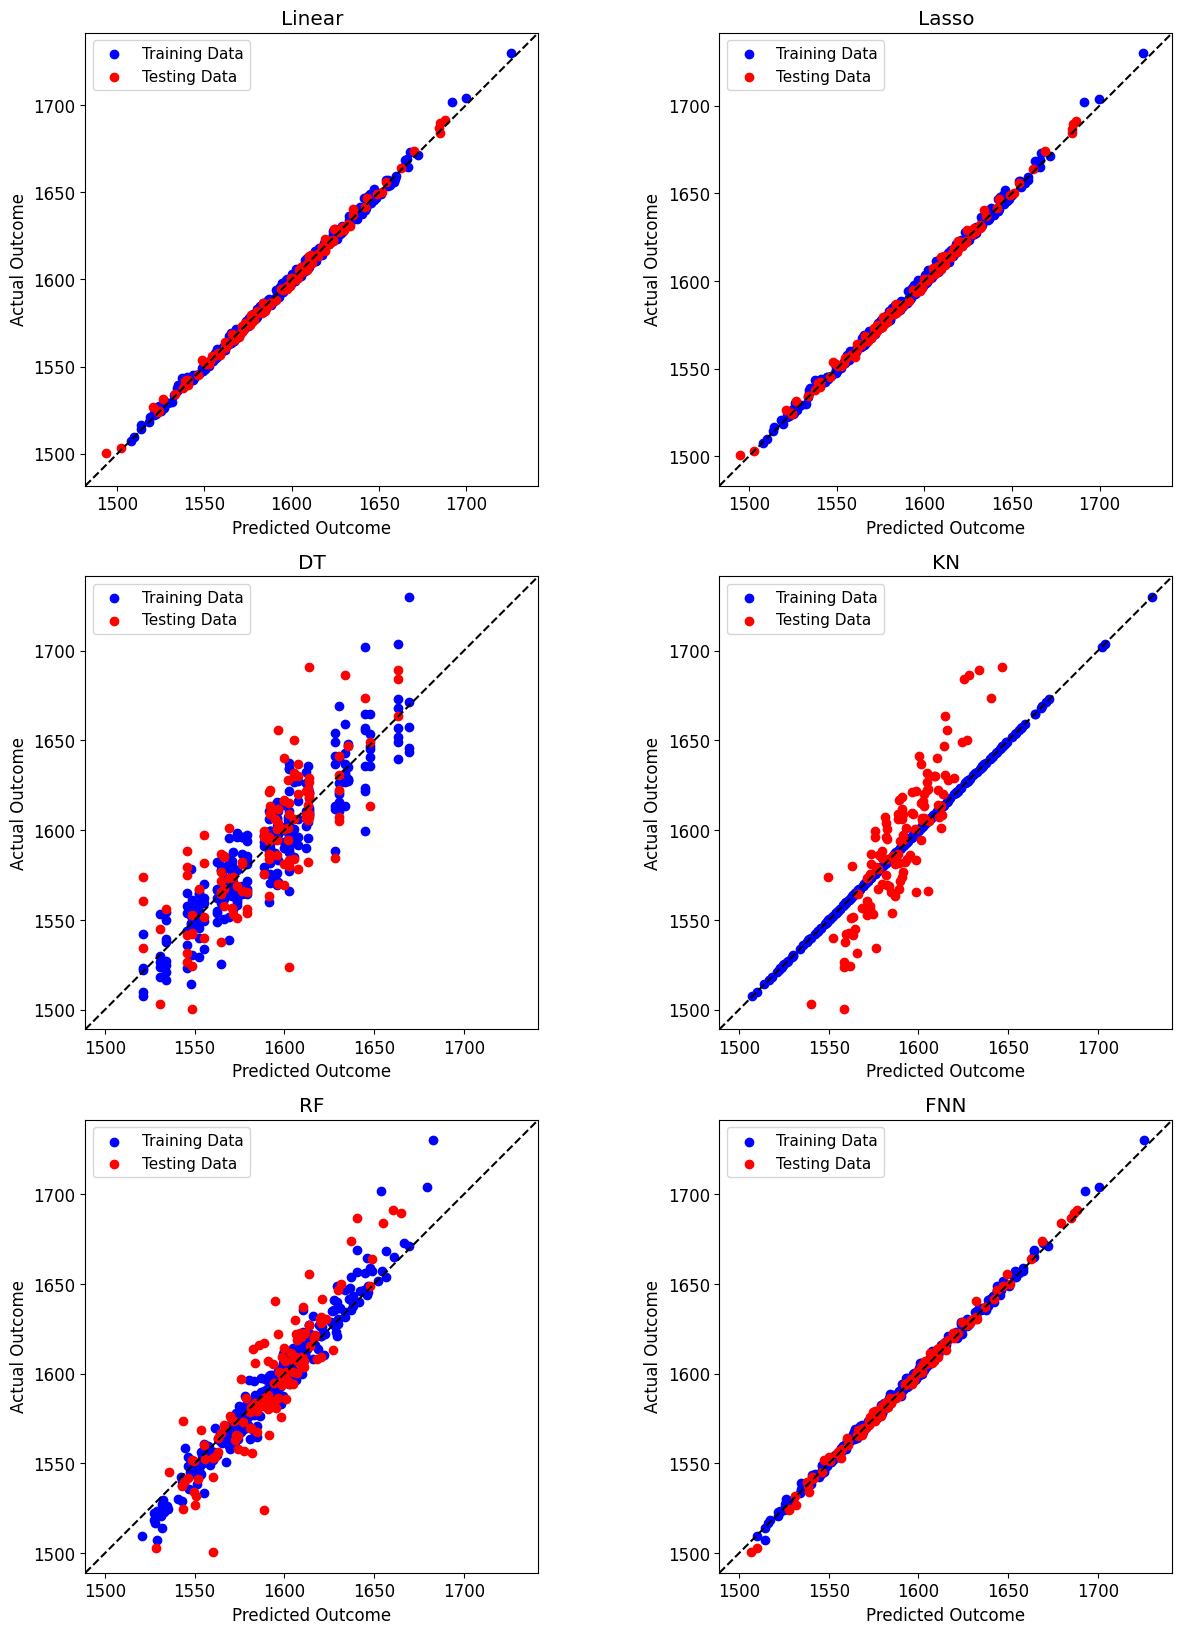

In [24]:
performance_plot(postprocessor.diagonal_validation_plot, "max_fuel_centerline_temp")

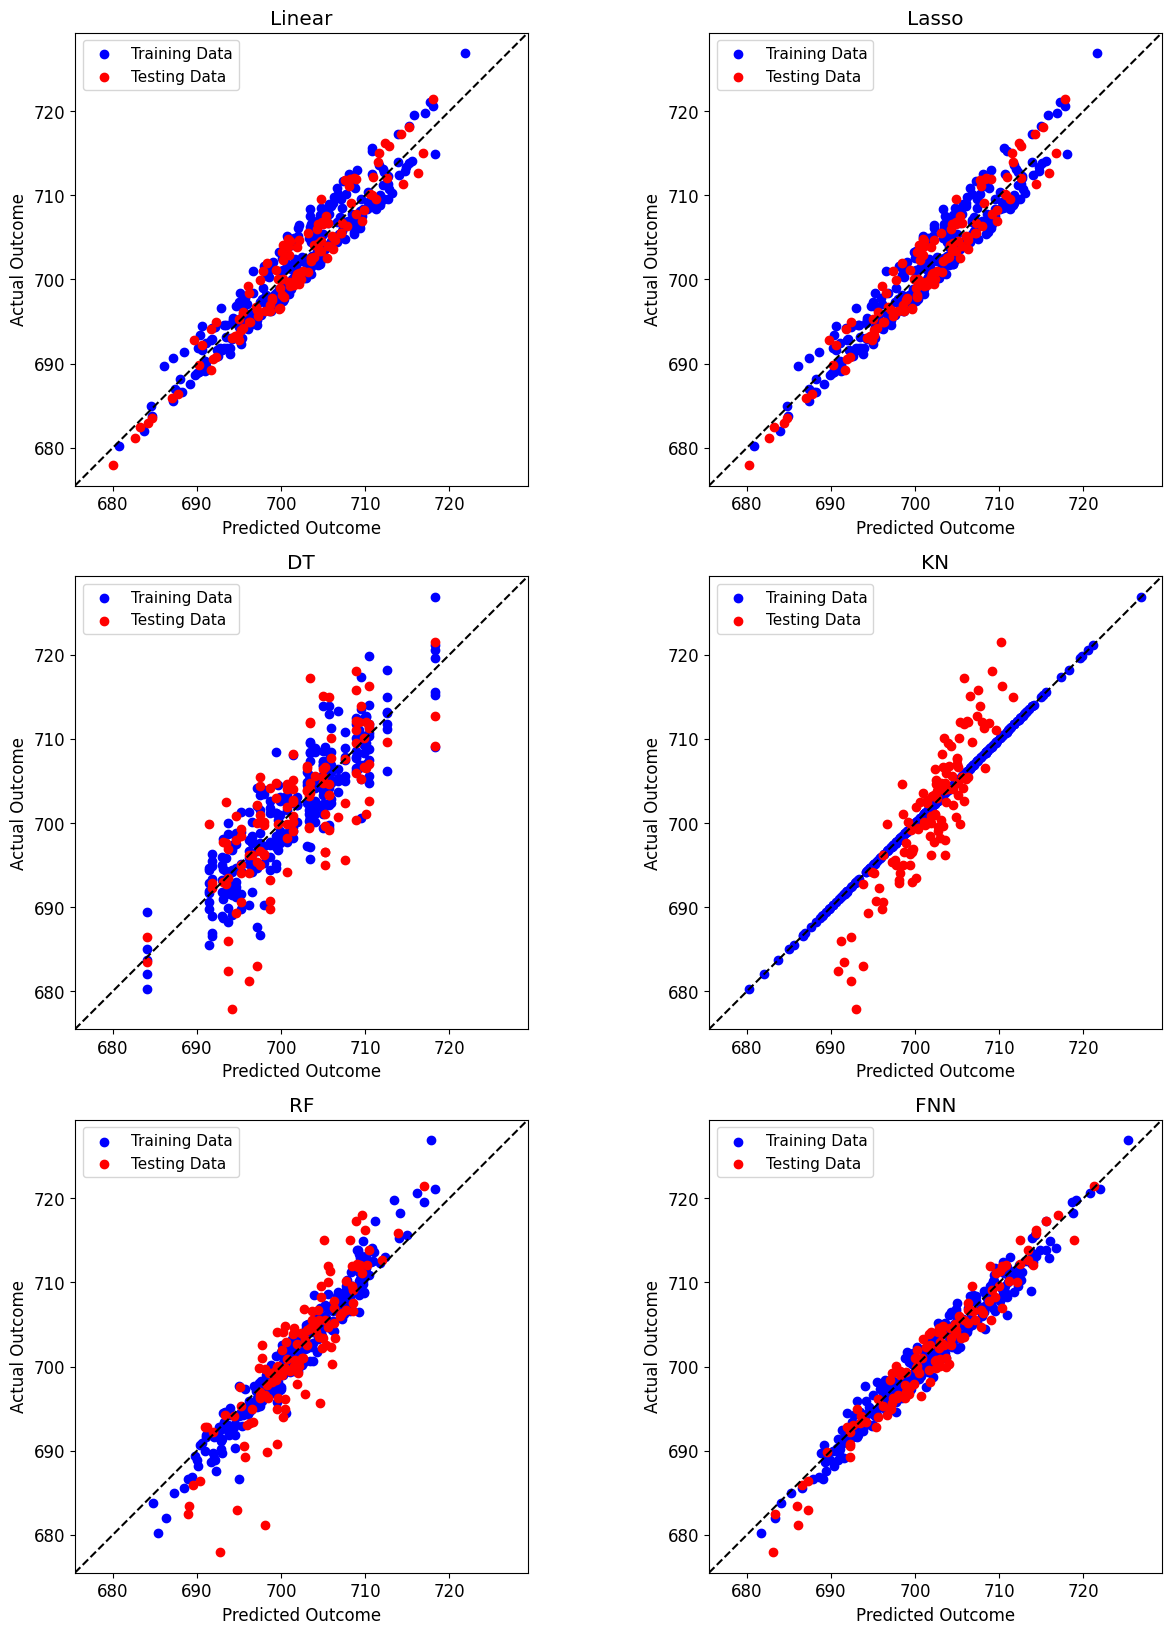

In [34]:
performance_plot(postprocessor.diagonal_validation_plot, "max_fuel_surface_temp")

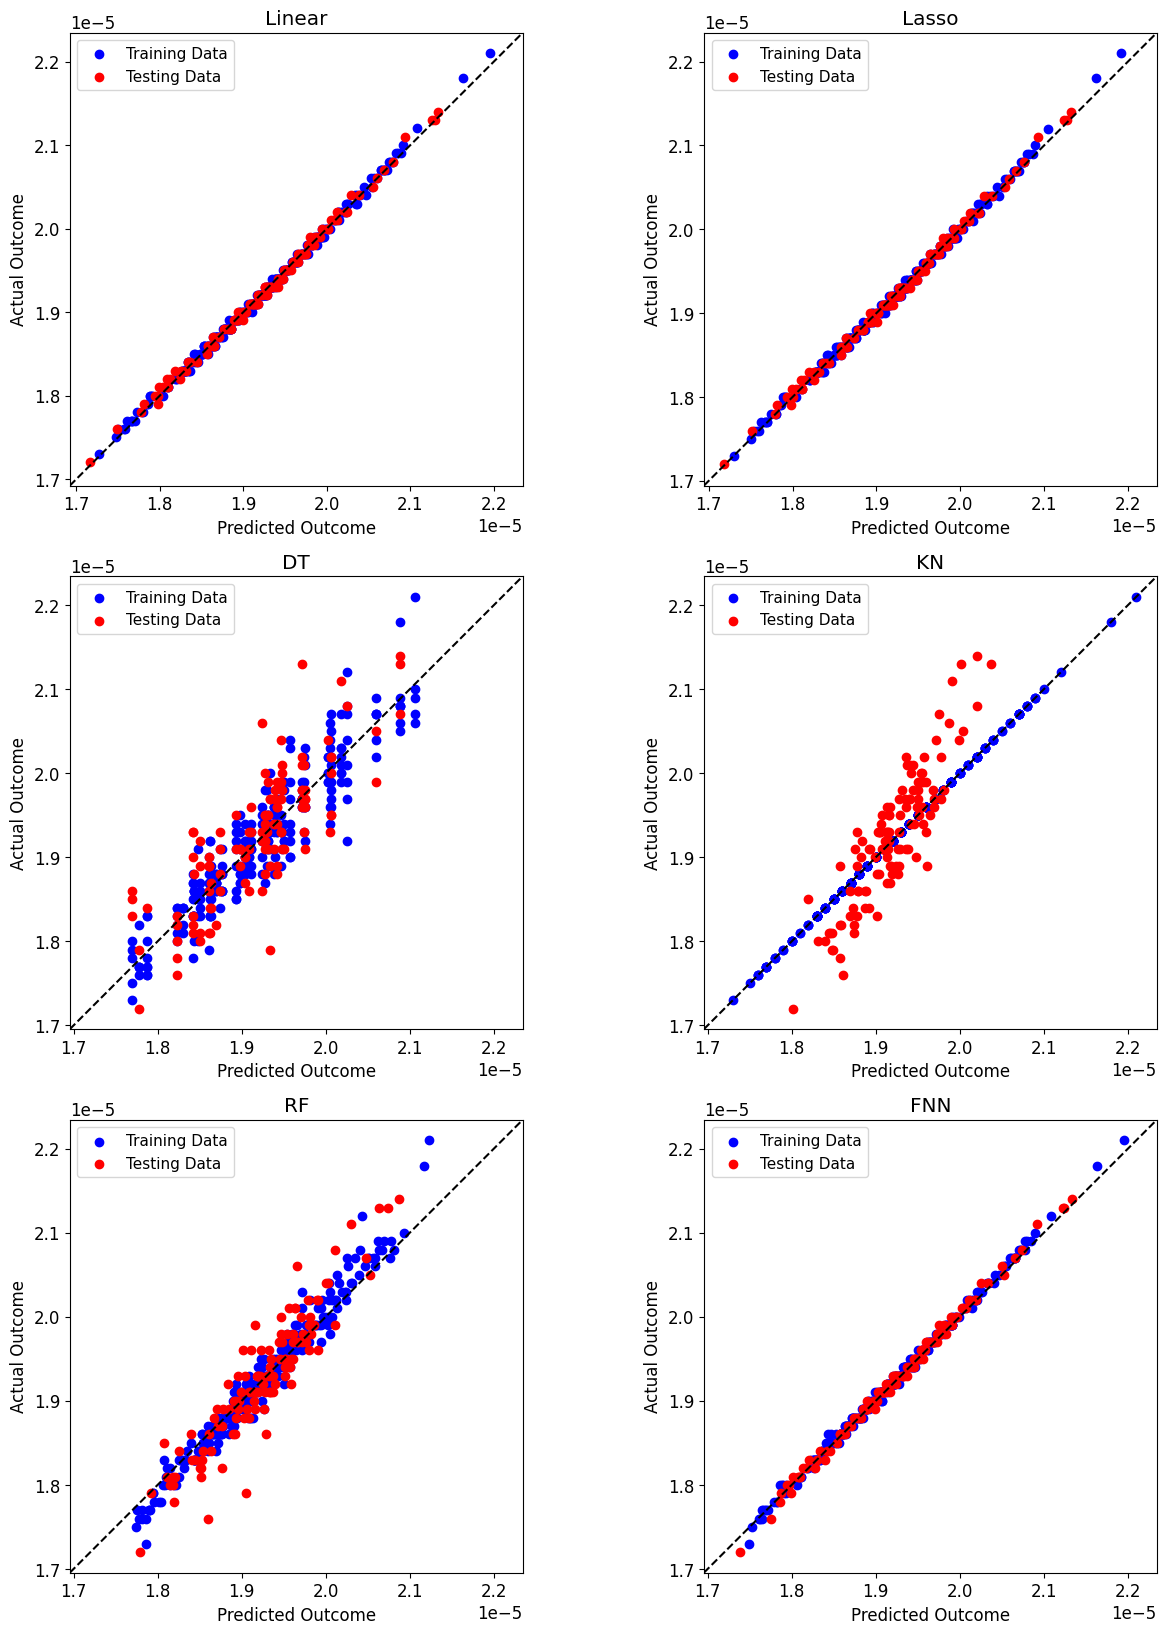

In [26]:
performance_plot(postprocessor.diagonal_validation_plot, "radial_clad_dia")

With these plots we can see the narrow spread of `Linear`, `Lasso`, and `FNN` to $y = x$, the best possible performance of a model. Additionally, `KN` appears to be overfit to the training data set and the preditions of `FNN` under 700 K under-approximate the max fuel surface temperature. 

Similarly, the `pyMAISE.PostProcessor.validation_plot` function produces validation plots that show the absolute relative error for each output.

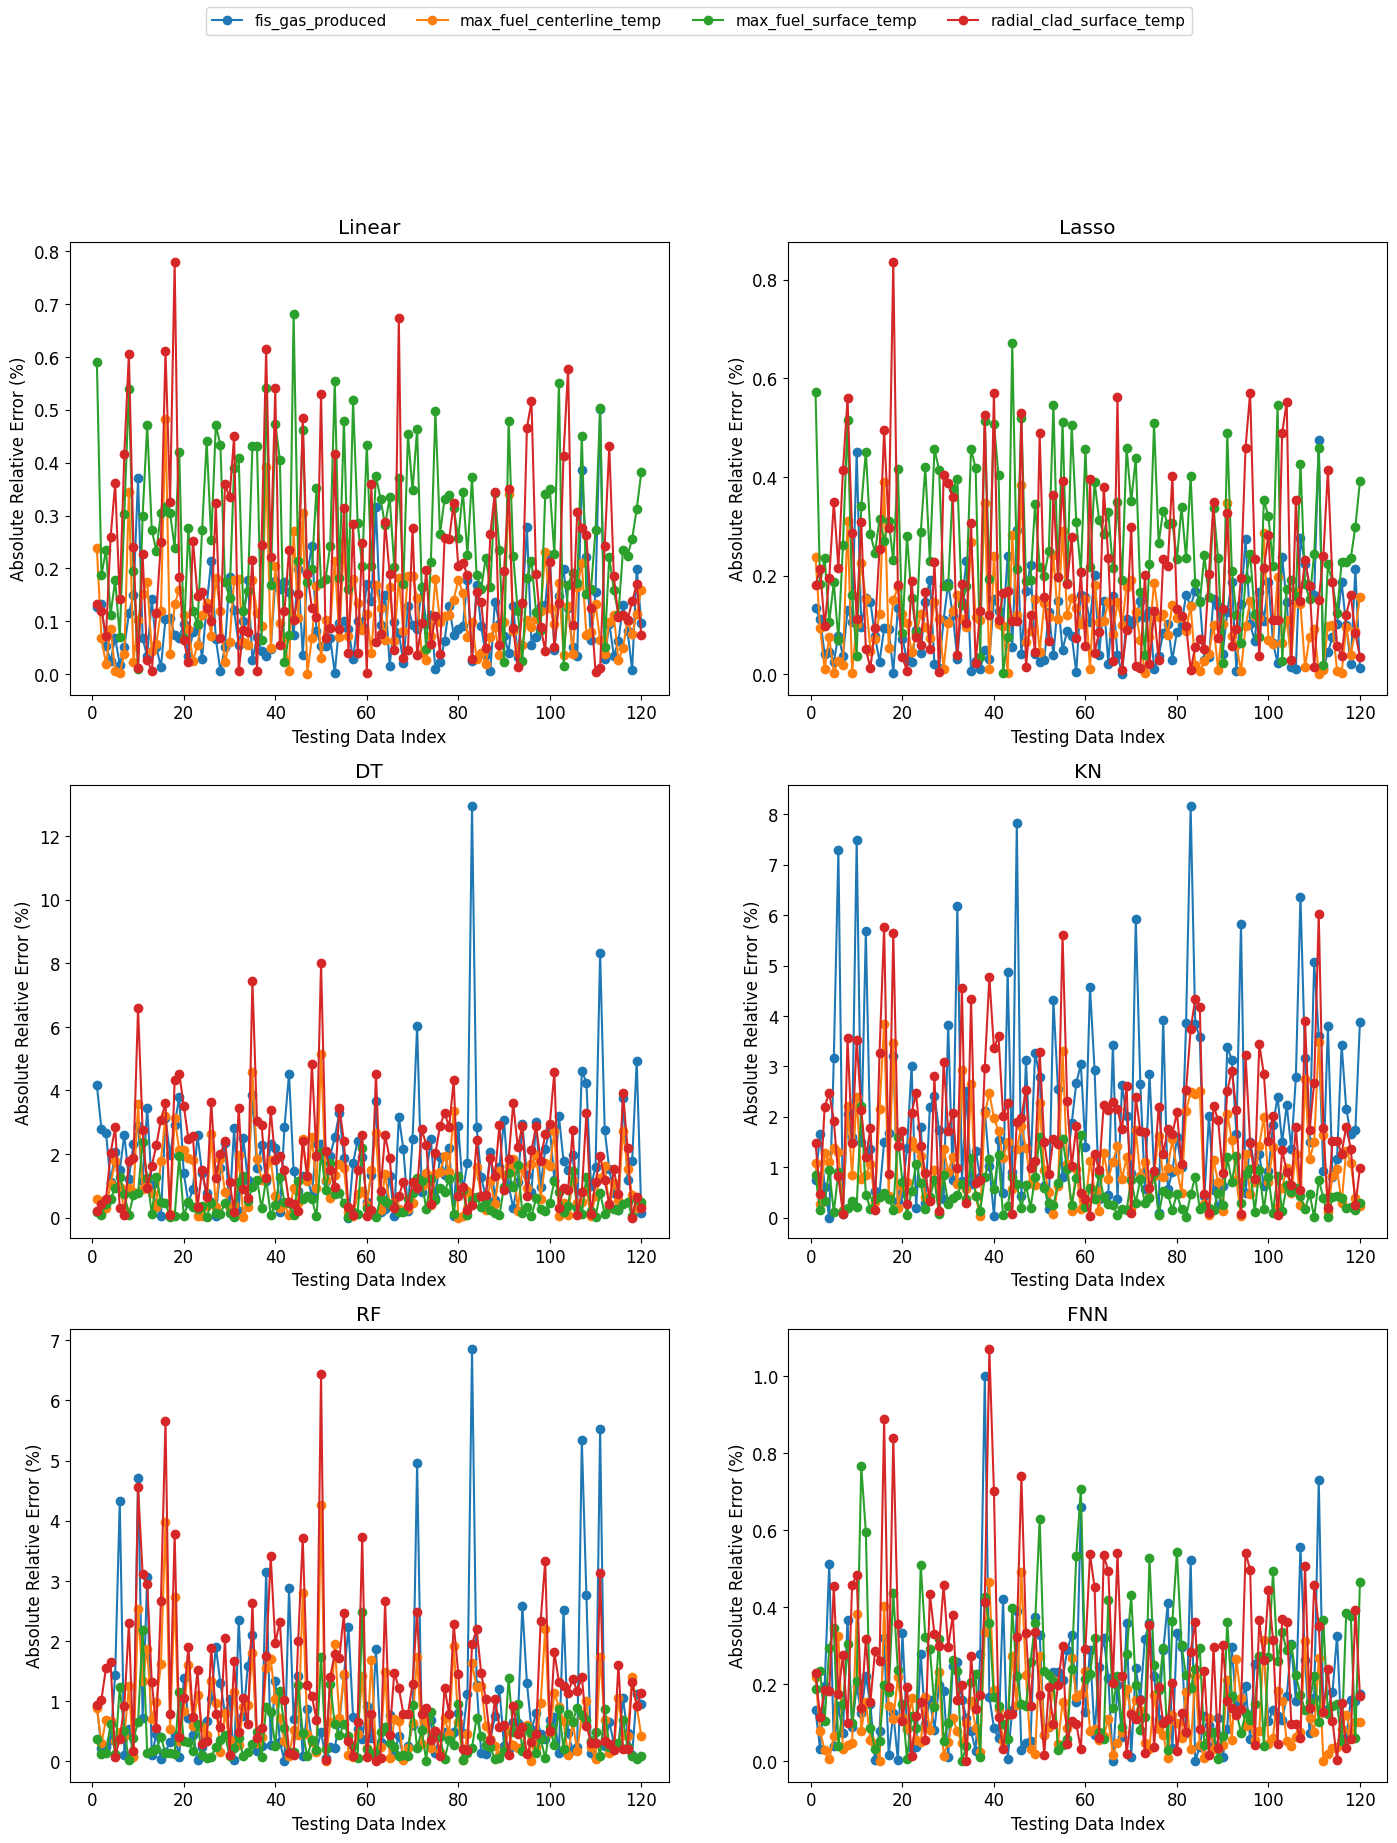

In [33]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])

fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,20))

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(
    ["fis_gas_produced", "max_fuel_centerline_temp", "max_fuel_surface_temp", "radial_clad_surface_temp"], 
    loc="upper center", 
    ncol=4
)

The performance gap of the linear model to the others is evident in the magnitude of the relative error.

Finally, the learning curve of the most performant `FNN` is shown by `pyMAISE.PostProcessor.nn_learning_plot`.

<Axes: xlabel='Epoch', ylabel='Loss'>

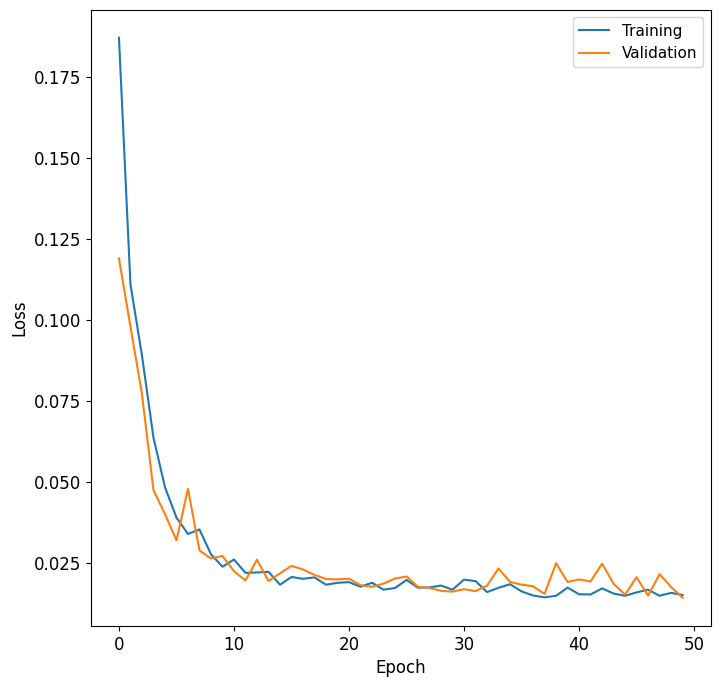

In [35]:
postprocessor.nn_learning_plot()

The validation curve is below the training curve; therefore, the best performing `FNN` is not overfit. 

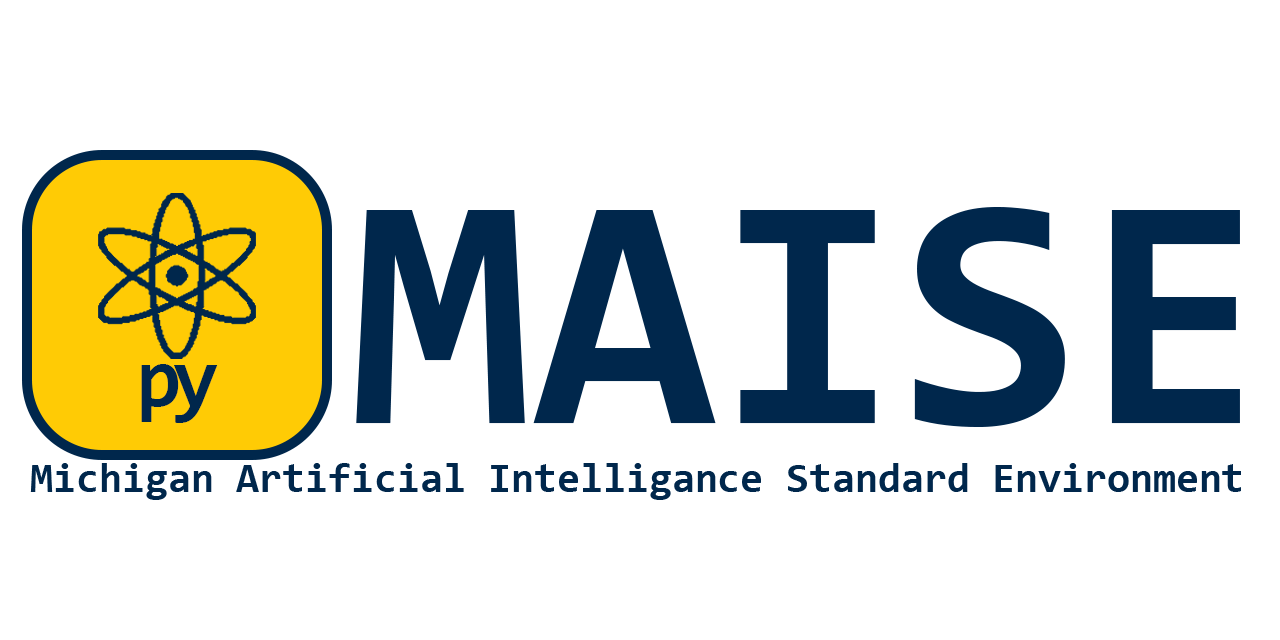